In [15]:
import numpy as np
import basics
import misc
import tensorflow as tf
from tensorflow.keras.layers import Dense
import random

basic = basics.Basics(resolution=.01)
basic.define_actions()
actions = basic.actions
ats = misc.make_attenuations(layers=2)

class Memory():
    def __init__(self, max_memory):
        self._max_memory = max_memory
        self._samples = []
    def add_sample(self, sample):
        self._samples.append(sample)
        if len(self._samples) > self._max_memory:
            self._samples.pop(0)
    def sample(self, no_samples):
        if no_samples > len(self._samples):
            return random.sample(self._samples, len(self._samples))
        else:
            return random.sample(self._samples, no_samples)
    @property
    def num_samples(self):
        return len(self._samples)



cardinality_betas = len(basic.actions[0])

class QN_l1(tf.keras.Model):
    def __init__(self):
        super(QN_l1,self).__init__()
        self.l1 = Dense(30, input_shape=(0,), kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0, seed=None),
                bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0, seed=None))
        self.l2 = Dense(35, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0, seed=None),
                bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0, seed=None))

        # self.l21 = Dense(90, kernel_initializer='random_uniform',
        #         bias_initializer='random_uniform')
        self.l3 = Dense(cardinality_betas, kernel_initializer='random_uniform',
                bias_initializer='random_uniform')

    def call(self, input):
        feat = tf.nn.relu(self.l1(input))
        feat = tf.nn.relu(self.l2(feat))
        # feat = tf.nn.relu(self.l21(feat))
        value = self.l3(feat)
        return value



class QN_l2(tf.keras.Model):
    def __init__(self):
        super(QN_l2,self).__init__()
        self.l1 = Dense(30, input_shape=(1,2), kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0, seed=None),
                bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0, seed=None))
        self.l2 = Dense(35, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0, seed=None),
                bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0, seed=None))

        # self.l21 = Dense(90, kernel_initializer='random_uniform',
        #         bias_initializer='random_uniform')
        self.l3 = Dense(cardinality_betas, kernel_initializer='random_uniform',
                bias_initializer='random_uniform')

    def call(self, input):
        feat = tf.nn.relu(self.l1(input))
        feat = tf.nn.relu(self.l2(feat))
        # feat = tf.nn.relu(self.l21(feat))
        value = self.l3(feat)
        return value

class QN_guess(tf.keras.Model):
    def __init__(self):
        super(QN_guess,self).__init__()
        self.l1 = Dense(30, input_shape=(1,4), kernel_initializer='random_uniform',
                bias_initializer='random_uniform')
        self.l2 = Dense(35, kernel_initializer='random_uniform',
                bias_initializer='random_uniform')

        # self.l21 = Dense(90, kernel_initializer='random_uniform',
        #         bias_initializer='random_uniform')
        self.l3 = Dense(2, kernel_initializer='random_uniform',
                bias_initializer='random_uniform')

    def call(self, input):
        feat = tf.nn.relu(self.l1(input))
        feat = tf.nn.relu(self.l2(feat))
        # feat = tf.nn.relu(self.l21(feat))
        value = self.l3(feat)
        return value


#### define the networks #####

qn_l1_prim = QN_l1()
qn_l1_targ = QN_l1()

qn_l2_prim = QN_l2()
qn_l2_targ = QN_l2()

qn_guess_prim = QN_guess()
qn_guess_targ = QN_guess()



def give_first_beta(epsilon):
    if np.random.random() < epsilon:
        label = np.random.choice(np.arange(len(basic.actions[0])))
        return label, basic.actions[0][label]
    else:
        input = np.expand_dims(np.array([]), axis=0)
        q1s = qn_l1_prim(input)
        q1s = q1s.numpy()
        label = np.argmax(q1s)
        beta1 = basic.actions[0][label]
        return label, beta1

def give_second_beta(new_state, epsilon):
    if np.random.random() < epsilon:
        label = np.random.choice(np.arange(len(basic.actions[1])))
        return label, basic.actions[1][label]
    else:
        input = np.expand_dims(np.array(new_state), axis=0)
        q2s = qn_l2_prim(input)
        q2s = q2s.numpy()
        label = np.argmax(q2s)
        beta2 = basic.actions[1][label]
        return label, beta2


def give_guess(new_state, epsilon):
    if np.random.random() < epsilon:
        guess = np.random.choice(basic.possible_phases,1)[0]
        return int((guess+1)/2), guess
    else:
        input = np.expand_dims(np.array(new_state), axis=0)
        qguess = qn_guess_prim(input)
        guess = qguess.numpy()
        label = np.argmax(guess)
        guess = basic.possible_phases[label]
        return int((guess+1)/2), guess
    
    
    
    
def learn():
    batch_length=32
    batch = buffer.sample(batch_length)

    s_2_batch = np.array([[ v[0], v[2]] for v in batch ] )
    labels_beta1 = np.array([v[4] for v in batch])

    q_2_prim = qn_l2_prim(np.expand_dims(s_2_batch, axis=0))
    q_2_prim = np.squeeze(q_2_prim.numpy())

    opt_a_2_prim = np.argmax(q_2_prim,axis=1)

    update_for_q_1_prim = qn_l1_targ(np.expand_dims(np.array([[] for i in range(len(batch))]), axis=0)) #targ = target
    update_for_q_1_prim = np.squeeze(update_for_q_1_prim, axis=0)
    qlabels_l1 = update_for_q_1_prim.copy()
    qlabels_l1[np.arange(batch_length), labels_beta1] = np.squeeze(qn_l2_targ(np.expand_dims(s_2_batch, axis=0)).numpy())[np.arange(batch_length),opt_a_2_prim]



    with tf.device("/cpu:0"):
        with tf.GradientTape() as tape:
            tape.watch(qn_l1_prim.trainable_variables)
            pred_q_1s = qn_l1_prim(np.expand_dims(np.array([[] for i in range(len(batch))]), axis=0))

            loss_sum =tf.keras.losses.MSE(pred_q_1s, qlabels_l1)
            loss = tf.reduce_mean(loss_sum)

            grads = tape.gradient(loss, qn_l1_prim.trainable_variables)

            optimizer_ql1.apply_gradients(zip(grads, qn_l1_prim.trainable_variables))
            
    s_2_batch = np.array([[v[0], v[2]] for v in batch])
    s_3_batch = np.array([[v[0], v[1], v[2], v[3]] for v in batch])

    #labels_guess = np.array([v[7] for v in batch])
    labels_action_2 = np.array([v[5] for v in batch])

    q_3_prim = qn_guess_prim(np.expand_dims(s_3_batch, axis=0))
    q_3_prim = np.squeeze(q_3_prim.numpy())

    opt_a_3_prim = np.argmax(q_3_prim, axis=1)

    update_for_q_2_prim = qn_l2_targ(np.expand_dims(s_2_batch, axis=0))
    update_for_q_2_prim = np.squeeze(update_for_q_2_prim, axis=0)
    qlabels_l2 = update_for_q_2_prim.copy()
    qlabels_l2[np.arange(batch_length), labels_action_2] = np.squeeze(qn_guess_targ(np.expand_dims(s_3_batch, axis=0)).numpy())[np.arange(batch_length), opt_a_3_prim]


    with tf.device("/cpu:0"):
        with tf.GradientTape() as tape:
            tape.watch(qn_l2_prim.trainable_variables)
            pred_q_2s = qn_l2_prim(np.expand_dims(s_2_batch, axis=0))
            loss_sum =tf.keras.losses.MSE(pred_q_2s, qlabels_l2)
            loss = tf.reduce_mean(loss_sum)

            grads = tape.gradient(loss, qn_l2_prim.trainable_variables)
            optimizer_ql2.apply_gradients(zip(grads, qn_l2_prim.trainable_variables))


    s_3_batch = np.array([[v[0], v[1], v[2], v[3]] for v in batch])
    rewards = np.array([v[-1] for v in batch])
    labels_guess = np.array([v[7] for v in batch])

    update_for_q_3_prim = qn_guess_targ(np.expand_dims(s_3_batch, axis=0))
    update_for_q_3_prim = np.squeeze(update_for_q_3_prim, axis=0)
    qlabels_l3 = update_for_q_3_prim.copy()
    qlabels_l3[np.arange(batch_length), labels_guess] = rewards[np.arange(batch_length)]


    with tf.device("/cpu:0"):
        with tf.GradientTape() as tape:
            tape.watch(qn_guess_prim.trainable_variables)
            pred_q_3s = qn_guess_prim(np.expand_dims(s_3_batch, axis=0))
            loss_sum =tf.keras.losses.MSE(pred_q_3s, qlabels_l3)
            loss = tf.reduce_mean(loss_sum)

            grads = tape.gradient(loss, qn_guess_prim.trainable_variables)
            optimizer_ql3.apply_gradients(zip(grads, qn_guess_prim.trainable_variables))
            
    for t, e in zip(qn_l1_targ.trainable_variables, qn_l1_prim.trainable_variables):
        t.assign(t*(1-TAU) + e*TAU)

    for t, e in zip(qn_l2_targ.trainable_variables, qn_l2_prim.trainable_variables):
        t.assign(t*(1-TAU) + e*TAU)

    for t, e in zip(qn_guess_targ.trainable_variables, qn_guess_prim.trainable_variables):
        t.assign(t*(1-TAU) + e*TAU)
    return
    


buffer = Memory(10**4)
optimizer_ql1 = tf.keras.optimizers.Adam(lr=0.001)
optimizer_ql2 = tf.keras.optimizers.Adam(lr=0.001)
optimizer_ql3 = tf.keras.optimizers.Adam(lr=0.001)

alpha = .56
states_wasted = 10**4
TAU = 0.08

cumulative = []
def main():
    cum_rews=0
    for episode in range(states_wasted):
        if episode%100 == 0:
            print(episode, " of ", states_wasted)

        epsilon = np.exp(-0.001*episode)
        phase = np.random.choice([-1,1],1)[0]
        labelbeta1, beta1 = give_first_beta(epsilon)
        p0 = np.exp(-(beta1-(phase*np.cos(ats[0])*alpha))**2)
        outcome1 = np.random.choice([0,1],1,p=[p0,1-p0])[0]
        new_state = [outcome1, beta1]
        labelbeta2, beta2 = give_second_beta(new_state,epsilon)
        p1 = np.exp(-(beta2-(phase*np.sin(ats[0])*alpha))**2)
        outcome2 = np.random.choice([0,1],1,p=[p1,1-p1])[0]
        new_state = [outcome1, outcome2, beta1, beta2]
        label_guess, guess = give_guess(new_state,epsilon)
        if guess == phase:
            reward = 1
        else:
            reward = 0
        buffer.add_sample((outcome1, outcome2, beta1, beta2, labelbeta1, labelbeta2, guess, label_guess, reward))
        if episode > 10**2:
            learn()
        cum_rews += reward
        cumulative.append(cum_rews)
    return cumulative
main()


W1103 15:30:06.593185 139929372481344 base_layer.py:1865] Layer qn_l1_10 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

W1103 15:30:06.607066 139929372481344 base_layer.py:1865] Layer qn_l2_10 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults t

0  of  10000
100  of  10000
200  of  10000
300  of  10000
400  of  10000
500  of  10000
600  of  10000
700  of  10000
800  of  10000
900  of  10000
1000  of  10000
1100  of  10000
1200  of  10000
1300  of  10000
1400  of  10000
1500  of  10000
1600  of  10000
1700  of  10000
1800  of  10000
1900  of  10000
2000  of  10000
2100  of  10000
2200  of  10000
2300  of  10000
2400  of  10000
2500  of  10000
2600  of  10000
2700  of  10000
2800  of  10000
2900  of  10000
3000  of  10000
3100  of  10000
3200  of  10000
3300  of  10000
3400  of  10000
3500  of  10000
3600  of  10000
3700  of  10000
3800  of  10000
3900  of  10000
4000  of  10000
4100  of  10000
4200  of  10000
4300  of  10000
4400  of  10000
4500  of  10000
4600  of  10000
4700  of  10000
4800  of  10000
4900  of  10000
5000  of  10000
5100  of  10000
5200  of  10000
5300  of  10000
5400  of  10000
5500  of  10000
5600  of  10000
5700  of  10000
5800  of  10000
5900  of  10000
6000  of  10000
6100  of  10000
6200  of  10000
6300

[0,
 1,
 1,
 2,
 3,
 4,
 4,
 5,
 5,
 6,
 6,
 6,
 7,
 7,
 8,
 8,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 11,
 12,
 12,
 12,
 12,
 13,
 13,
 13,
 13,
 13,
 13,
 14,
 15,
 16,
 16,
 17,
 17,
 17,
 17,
 18,
 18,
 19,
 19,
 20,
 21,
 21,
 21,
 21,
 21,
 21,
 22,
 22,
 23,
 24,
 24,
 24,
 24,
 25,
 26,
 26,
 27,
 28,
 28,
 29,
 29,
 29,
 30,
 31,
 31,
 31,
 32,
 32,
 32,
 33,
 34,
 34,
 34,
 34,
 35,
 36,
 37,
 38,
 38,
 38,
 38,
 39,
 39,
 40,
 40,
 41,
 41,
 41,
 42,
 42,
 43,
 43,
 44,
 44,
 44,
 45,
 46,
 46,
 46,
 46,
 46,
 47,
 47,
 47,
 48,
 48,
 48,
 48,
 49,
 49,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 56,
 57,
 58,
 58,
 59,
 59,
 59,
 60,
 60,
 61,
 62,
 62,
 62,
 62,
 63,
 64,
 65,
 65,
 65,
 66,
 67,
 67,
 67,
 68,
 68,
 69,
 70,
 70,
 71,
 72,
 72,
 73,
 74,
 75,
 75,
 75,
 75,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 81,
 82,
 82,
 83,
 84,
 85,
 85,
 85,
 86,
 86,
 87,
 87,
 88,
 88,
 89,
 89,
 90,
 90,
 91,
 92,
 92,
 93,
 93,
 94,
 94,
 94,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 96,


In [19]:
cumulative/np.arange(1,states_wasted+1)

array([0.        , 0.5       , 0.33333333, ..., 0.81856371, 0.81858186,
       0.8186    ])

In [23]:
np.where(cumulative/np.arange(1,states_wasted+1) > 0.8)

(array([7295, 7296, 7297, ..., 9997, 9998, 9999]),)

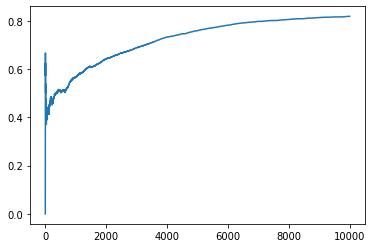

In [21]:
plt.plot(cumulative/np.arange(1,states_wasted+1))

In [27]:
100*2*100*2*2

80000